# T81-558: Applications of Deep Neural Networks
**Class 3: Training a Neural Network**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Building the Feature Vector

Neural networks require their input to be a fixed number of columns.  This is very similar to spreadsheet data.  This input must be completely numeric.  

It is important to represent the data in a way that the neural network can train from it.  In class 6, we will see even more ways to preprocess data.  For now, we will look at several of the most basic ways to transform data for a neural network.

Before we look at specific ways to preprocess data, it is important to consider four basic types of data, as defined by [Stanley Smith Stevens](https://en.wikipedia.org/wiki/Stanley_Smith_Stevens).  These are commonly referred to as the [levels of measure](https://en.wikipedia.org/wiki/Level_of_measurement):

* Character Data (strings)
    * **Nominal** - Individual discrete items, no order. For example: color, zip code, shape.
    * **Ordinal** - Individual discrete items that can be ordered.  For example: grade level, job title, Starbucks(tm) coffee size (tall, vente, grande) 
* Numeric Data
    * **Interval** - Numeric values, no defined start.  For example, temperature.  You would never say "yesterday was twice as hot as today".
    * **Ratio** - Numeric values, clearly defined start.  For example, speed.  You would say that "The first car is going twice as fast as the second."

The following code contains several useful functions to encode the feature vector for various types of data.  Encoding data:

* **encode_text_dummy** - Encode text fields, such as the iris species as a single field for each class.  Three classes would become "0,0,1" "0,1,0" and "1,0,0". Encode non-target predictors this way. Good for nominal.
* **encode_text_index** - Encode text fields, such as the iris species as a single numeric field as "0" "1" and "2".  Encode the target field for a classification this way.  Good for nominal.
* **encode_numeric_zscore** - Encode numeric values as a z-score.  Neural networks deal well with "centered" fields, zscore is usually a good starting point for interval/ratio.

*Ordinal values can be encoded as dummy or index.  Later we will see a more advanced means of encoding*

Dealing with missing data:

* **missing_median** - Fill all missing values with the median value.

Creating the final feature vector:

* **to_xy** - Once all fields are numeric, this function can provide the x and y matrixes that are used to fit the neural network.

Other utility functions:

* **hms_string** - Print out an elapsed time string.
* **chart_regression** - Display a chart to show how well a regression performs.


In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the origional column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df,name,target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x)==str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name,tv)
        df[name2] = l
    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart, we will see more of this chart in the next class.
def chart_regression(pred,y):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Get a new directory to hold checkpoints from a neural network.  This allows the neural network to be
# loaded later.  If the erase param is set to true, the contents of the directory will be cleared.
def get_model_dir(name,erase):
    base_path = os.path.join(".","dnn")
    model_dir = os.path.join(base_path,name)
    os.makedirs(model_dir,exist_ok=True)
    if erase and len(model_dir)>4 and os.path.isdir(model_dir):
        shutil.rmtree(model_dir,ignore_errors=True) # be careful, this deletes everything below the specified path
    return model_dir

# Training with a Validation Set and Early Stopping

**Overfitting** occurs when a neural network is trained to the point that it begins to memorize rather than generalize.  

![Training vs Validation Error for Overfitting](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_3_training_val.png "Training vs Validation Error for Overfitting")

It is important to segment the original dataset into several datasets:

* **Training Set**
* **Validation Set**
* **Holdout Set**

There are several different ways that these sets can be constructed.  The following programs demonstrate some of these.

The first method is a training and validation set.  The training data are used to train the neural network until the validation set no longer improves.  This attempts to stop at a near optimal training point.  This method will only give accurate "out of sample" predictions for the validation set, this is usually 20% or so of the data.  The predictions for the training data will be overly optimistic, as these were the data that the neural network was trained on.  

![Training with a Validation Set](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_1_train_val.png "Training with a Validation Set")


In [37]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.contrib.learn as learn
import numpy as np
from tensorflow.contrib.learn.python.learn.metric_spec import MetricSpec

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.INFO)

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

# Encode feature vector
encode_numeric_zscore(df,'petal_w')
encode_numeric_zscore(df,'petal_l')
encode_numeric_zscore(df,'sepal_w')
encode_numeric_zscore(df,'sepal_l')
species = encode_text_index(df,"species")
num_classes = len(species)

# Create x & y for training

# Create the x-side (feature vectors) of the training
x, y = to_xy(df,'species')
    
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)

# Get/clear a directory to store the neural network to
model_dir = get_model_dir('iris',True)

# Create a deep neural network with 3 hidden layers of 10, 20, 5
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
classifier = learn.DNNClassifier(
    model_dir= model_dir,
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    hidden_units=[10, 20, 5], n_classes=num_classes, feature_columns=feature_columns)

# Might be needed in future versions of "TensorFlow Learn"
#classifier = learn.SKCompat(classifier) # For Sklearn compatibility

# Early stopping
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=500,
    #metrics=validation_metrics,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=50)
    
# Fit/train neural network
classifier.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)
    

INFO:tensorflow:Using config: {'keep_checkpoint_max': 5, 'save_checkpoints_steps': None, '_task_type': None, '_task_id': 0, 'save_summary_steps': 100, '_evaluation_master': '', 'keep_checkpoint_every_n_hours': 10000, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_num_ps_replicas': 0, 'save_checkpoints_secs': 1, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000186F7BB3E10>, '_is_chief': True, '_environment': 'local'}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving in

# Calculate Classification Accuracy
 
Accuracy is the number of rows where the neural network correctly predicted the target class.  Accuracy is only used for classification, not regression.

$ accuracy = \frac{\textit{#} \ correct}{N} $

Where $N$ is the size of the evaluted set (training or validation). Higher accuracy numbers are desired.

In [38]:
from sklearn import metrics

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

# Evaluate success using accuracy
pred = list(classifier.predict(x_test, as_iterable=True))
score = metrics.accuracy_score(y_test, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.9473684210526315


# Calculate Classification Log Loss

Accuracy is like a final exam with no partial credit.  However, neural networks can predict a probability of each of the target classes.  Neural networks will give high probabilities to predictions that are more likely.  Log loss is an error metric that penalizes confidence in wrong answers. Lower log loss values are desired.

For any scikit-learn model there are two ways to get a prediction:

* **predict** - In the case of classification output the numeric id of the predicted class.  For regression, this is simply the prediction.
* **predict_proba** - In the case of classification output the probability of each of the classes.  Not used for regression.

The following code shows the output of predict_proba:


In [23]:
# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
pred = list(classifier.predict_proba(x_test, as_iterable=True))

print("Numpy array of predictions")
print(pred[0]*100)

print("As percent probability")
display(pred[0:5])

score = metrics.log_loss(y_test, pred)
print("Log loss score: {}".format(score))

Numpy array of predictions
[ 99.9671   0.0329   0.    ]
As percent probability


[array([ 0.9997,  0.0003,  0.    ], dtype=float32),
 array([ 0.9992,  0.0008,  0.    ], dtype=float32),
 array([ 0.   ,  0.074,  0.926], dtype=float32),
 array([ 0.9998,  0.0002,  0.    ], dtype=float32),
 array([ 0.9996,  0.0004,  0.    ], dtype=float32)]

Log loss score: 0.1335913760878767


[Log loss](https://www.kaggle.com/wiki/LogarithmicLoss) is calculated as follows:

$ \text{log loss} = -\frac{1}{N}\sum_{i=1}^N {( {y}_i\log(\hat{y}_i) + (1 - {y}_i)\log(1 - \hat{y}_i))} $

The log function is useful to penalizing wrong answers.  The following code demonstrates the utility of the log function:

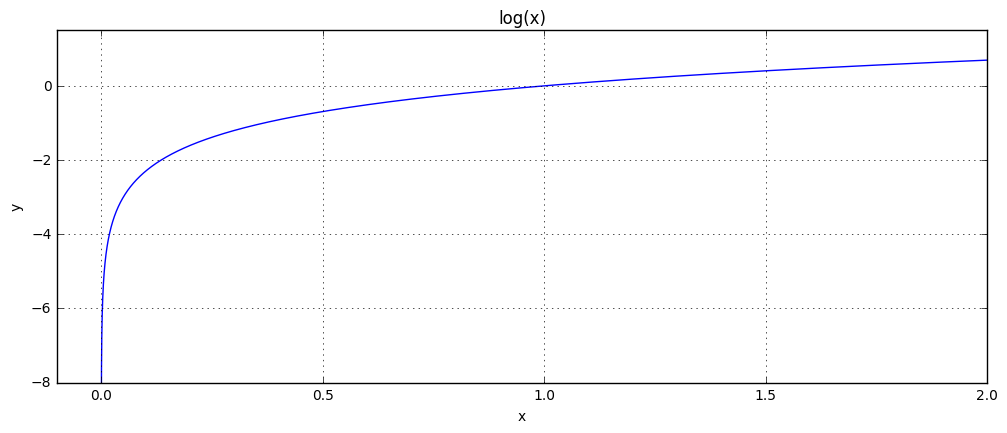

In [27]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange, sin, pi

t = arange(1e-5, 5.0, 0.00001)
#t = arange(1.0, 5.0, 0.00001) # computer scientists
#t = arange(0.0, 1.0, 0.00001)  # data     scientists

fig = figure(1,figsize=(12, 10))

ax1 = fig.add_subplot(211)
ax1.plot(t, np.log(t))
ax1.grid(True)
ax1.set_ylim((-8, 1.5))
ax1.set_xlim((-0.1, 2))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('log(x)')

show()

# Evaluating Regression Results

Regression results are evaluated differently than classification.  Consider the following code that trains a neural network for the [MPG dataset](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/datasets_mpg.ipynb). 

In [46]:
import tensorflow.contrib.learn as learn
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

path = "./data/"

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.INFO)

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

# Get/clear a directory to store the neural network to
model_dir = get_model_dir('mpg',True)

# Create a deep neural network with 3 hidden layers of 50, 25, 10
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
regressor = learn.DNNRegressor(
    model_dir= model_dir,
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    feature_columns=feature_columns,
    hidden_units=[50, 25, 10])

# Might be needed in future versions of "TensorFlow Learn"
#classifier = learn.SKCompat(classifier) # For Sklearn compatibility

# Early stopping
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=500,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=50)
    
# Fit/train neural network
regressor.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)


INFO:tensorflow:Using config: {'keep_checkpoint_max': 5, 'save_checkpoints_steps': None, '_task_type': None, '_task_id': 0, 'save_summary_steps': 100, '_evaluation_master': '', 'keep_checkpoint_every_n_hours': 10000, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_num_ps_replicas': 0, 'save_checkpoints_secs': 1, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000186F93D2710>, '_is_chief': True, '_environment': 'local'}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving in

DNNRegressor(hidden_units=[50, 25, 10], optimizer=None, feature_columns=[_RealValuedColumn(column_name='', dimension=398, default_value=None, dtype=tf.float32, normalizer=None)], dropout=None)

### Mean Square Error

The mean square error is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$).  MSE values are not of a particular unit.  If an MSE value has decreased for a model, that is good.  However, beyond this, there is not much more you can determine.  Low MSE values are desired.

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $


In [42]:
# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

# Predict
pred = list(regressor.predict(x_test, as_iterable=True))

# Measure MSE error.  
score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

Final score (MSE): 7.481411933898926


### Root Mean Square Error

The root mean square (RMSE) is essentially the square root of the MSE.  Because of this, the RMSE error is in the same units as the training data outcome. Low RMSE values are desired.

$ \text{MSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2} $

In [43]:
# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 2.7352170944213867


# Training with Cross Validation

Cross validation uses a number of folds, and multiple models, to generate out of sample predictions on the entire dataset.  It is important to note that there will be one model (neural network) for each fold. Each model contributes part of the final out-of-sample prediction.

![K-Fold Crossvalidation](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_1_kfold.png "K-Fold Crossvalidation")

For new data, which is data not present in the training set, predictions from the fold models can be handled in several ways.

* Choose the model that had the highest validation score as the final model.
* Preset new data to the 5 models and average the result (this is an [enesmble](https://en.wikipedia.org/wiki/Ensemble_learning)).
* Retrain a new model (using the same settings as the crossvalidation) on the entire dataset.  Train for as many steps, and with the same hidden layer structure.

The following code trains the MPG dataset using a 5-fold cross validation.  The expected performance of a neural network, of the type trained here, would be the score for the generated out-of-sample predictions.

In [49]:
import tensorflow.contrib.learn as learn
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
filename_write = os.path.join(path,"auto-mpg-out-of-sample.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Cross validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0
for train, test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    # Get/clear a directory to store the neural network to
    model_dir = get_model_dir('mpg-{}'.format(fold),True) # Each fold has its own folder

    # Create a deep neural network with 3 hidden layers of 50, 25, 10
    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
    regressor = learn.DNNRegressor(
        model_dir= model_dir,
        config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
        feature_columns=feature_columns,
        hidden_units=[50, 25, 10])

    # Might be needed in future versions of "TensorFlow Learn"
    #classifier = learn.SKCompat(classifier) # For Sklearn compatibility

    # Early stopping
    validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
        x_test,
        y_test,
        every_n_steps=50,
        early_stopping_metric="loss",
        early_stopping_metric_minimize=True,
        early_stopping_rounds=50)
    
    # Fit/train neural network
    regressor.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)

    # Add the predictions to the oos prediction list
    pred = list(regressor.predict(x_test, as_iterable=True))
    
    oos_y.append(y_test)
    oos_pred.append(pred)        

    # Measure accuracy
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print("Final, out of sample score (RMSE): {}".format(score))    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
oosDF.to_csv(filename_write,index=False)


Fold #1
Fold score (RMSE): 2.8336174488067627
Fold #2
Fold score (RMSE): 3.4074041843414307
Fold #3
Fold score (RMSE): 3.2617008686065674
Fold #4
Fold score (RMSE): 3.995164632797241
Fold #5
Fold score (RMSE): 3.520904541015625
Final, out of sample score (RMSE): 3.422718048095703


# Training with Cross Validation and a Holdout Set

If you have a considerable amount of data, it is always valuable to set aside a holdout set before you crossvalidate.  This hold out set will be the final evaluation before you make use of your model for its real-world use.

![Cross Validation and a Holdout Set](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_3_hold_train_val.png "Cross Validation and a Holdout Set")

The following program makes use of a holdout set, and then still cross validates.  

In [52]:
import tensorflow.contrib.learn as learn
from sklearn.cross_validation import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
filename_write = os.path.join(path,"auto-mpg-holdout.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')


# Keep a 10% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.10) 


# Cross validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0
for train, test in kf.split(x_main):        
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
    
    # Get/clear a directory to store the neural network to
    model_dir = get_model_dir('mpg-{}'.format(fold),True) # Each fold has its own folder

    # Create a deep neural network with 3 hidden layers of 50, 25, 10
    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
    regressor = learn.DNNRegressor(
        model_dir= model_dir,
        config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
        feature_columns=feature_columns,
        hidden_units=[50, 25, 10])

    # Might be needed in future versions of "TensorFlow Learn"
    #classifier = learn.SKCompat(classifier) # For Sklearn compatibility

    # Early stopping
    validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
        x_test,
        y_test,
        every_n_steps=50,
        early_stopping_metric="loss",
        early_stopping_metric_minimize=True,
        early_stopping_rounds=50)
    
    # Fit/train neural network
    regressor.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)

    # Add the predictions to the oos prediction list
    pred = list(regressor.predict(x_test, as_iterable=True))
    
    oos_y.append(y_test)
    oos_pred.append(pred)        

    # Measure accuracy
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print()
print("Cross-validated score (RMSE): {}".format(score))    
    
# Write the cross-validated prediction (from the last neural network)
holdout_pred = list(regressor.predict(x_holdout, as_iterable=True))

score = np.sqrt(metrics.mean_squared_error(holdout_pred,y_holdout))
print("Holdout score (RMSE): {}".format(score))    


Fold #1
Fold score (RMSE): 3.6610658168792725
Fold #2
Fold score (RMSE): 3.3233776092529297
Fold #3
Fold score (RMSE): 3.479468584060669
Fold #4
Fold score (RMSE): 3.090214729309082
Fold #5
Fold score (RMSE): 3.59272837638855

Cross-validated score (RMSE): 3.4359307289123535
Holdout score (RMSE): 2.9079461097717285


# How Kaggle Competitions are Scored

[Kaggle](https://www.kaggle.com/) is a platform for competitive data science. Competitions are posted onto Kaggle by companies seeking the best model for their data.  Competing in a Kaggle competition is quite a bit of work, I've [competed in one Kaggle competition](https://www.kaggle.com/jeffheaton).   

Kaggle awards "tiers", such as:

* Kaggle Grandmaster
* Kaggle Master
* Kaggle Expert

Your [tier](https://www.kaggle.com/progression) is based on your performance in past competitions.  

To compete in Kaggle you simply provide predictions for a dataset that they post.  You do not need to submit any code.  Your prediction output will place you onto the [leaderboard of a competition](https://www.kaggle.com/c/otto-group-product-classification-challenge/leaderboard/public).

![How Kaggle Competitions are Scored](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_3_kaggle.png "How Kaggle Competitions are Scored")

An original dataset is sent to Kaggle by the company.  From this dataset, Kaggle posts public data that includes "train" and "test.  For the "train" data, the outcomes (y) are provided.  For the test data, no outcomes are provided.  Your submission file contains your predictions for the "test data".  When you submit your results, Kaggle will calculate a score on part of your prediction data.  They do not publish want part of the submission data are used for the public and private leaderboard scores (this is a secret to prevent overfitting).  While the competition is still running, Kaggle publishes the public leaderboard ranks.  Once the competition ends, the private leaderboard is revealed to designate the true winners.  Due to overfitting, there is sometimes an upset in positions when the final private leaderboard is revealed.  

# Managing Hyperparameters

There are many different settings that you can use for a neural network.  These can affect performance.  The following code changes some of these, beyond their default values:

Score (RMSE): 2.7645113468170166


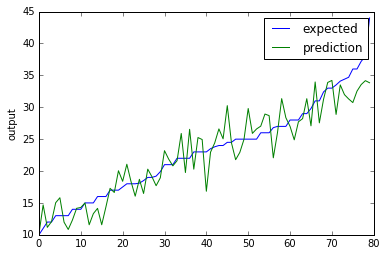

In [3]:
%matplotlib inline
from matplotlib.pyplot import figure, show
import tensorflow.contrib.learn as learn
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import tensorflow as tf

path = "./data/"

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

# Get/clear a directory to store the neural network to
model_dir = get_model_dir('mpg',True)

# Choose an optimizer
opt=tf.train.AdamOptimizer(learning_rate=0.01)
#opt=tf.train.MomentumOptimizer(learning_rate=0.000001,momentum=0.9)

# Create a deep neural network with 3 hidden layers of 50, 25, 10
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
regressor = learn.DNNRegressor(
    model_dir= model_dir,
    #optimizer=opt,
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    feature_columns=feature_columns,
    hidden_units=[50,25,5])

# Might be needed in future versions of "TensorFlow Learn"
#classifier = learn.SKCompat(classifier) # For Sklearn compatibility

# Early stopping
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=100,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=100)
    
# Fit/train neural network
regressor.fit(x_train, y_train,monitors=[validation_monitor],batch_size=32,steps=10000)

# Predict and measure RMSE
pred = list(regressor.predict(x_test, as_iterable=True))
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred,y_test)
